## 0. Loading Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import git
from pathlib import Path
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import pathlib
import shutil
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform_audio import *
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.npyio')

## 1. Select transform type and group

In [2]:
groups = {3: ['normal_intensity', 'strong_intensity'], 4: ['statement_1', 'statement_2'], 6: ['male', 'female']}
group = 6
categories = {3: 'emotional intensity', 4: 'statement', 6: 'gender'}

CATEGORY_NAME = categories[group]
GROUP_NAMES = groups[group]

# Suffix used to construct internal filenames
transform_affix = 'cwt'

KS_THRESHOLD = 0.05  

# --- Path Definitions ---
DATA_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')
PATHS = {
    "Original-Pitch": {
        "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}_freqs.npy')
    },
    "Pitch-Normalized": {
        "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_freqs.npy')
    }
}

print("✅ Loaded successfully.")
print(f"Analysis Category: {CATEGORY_NAME.replace('_', ' ').title()} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]})")
print(f"KS Test Decision Threshold: {KS_THRESHOLD}")

✅ Loaded successfully.
Analysis Category: Gender (male vs female)
KS Test Decision Threshold: 0.05


## 2. Analysis Functions

In [ ]:
def preprocess_and_save_by_band(coefs_npz_path, unified_bands_indices, temp_dir, group_id, group_map):
    print(f"  - Step 1: Pre-processing and sharding data by band to: {temp_dir}")
    
    current_group_names = group_map[group_id]
    
    file_writers = {}
    for i, _ in enumerate(unified_bands_indices):
        file_writers[i] = {}
        for group_name in current_group_names:
            temp_file_path = temp_dir / f"band_{i}_{group_name}.bin"
            file_writers[i][group_name] = open(temp_file_path, 'wb')

    with np.load(coefs_npz_path, allow_pickle=True) as data:
        total_files = len(data.files)
        print(f"  - Found {total_files} files in NPZ archive. Starting sharding...")
        for i, item in enumerate(data.files):
            if (i + 1) % 200 == 0:
                print(f"    - Sharding file {i+1}/{total_files}...")
            
            try:
                base_filename = item.split('_')[0]
                actor_id = int(base_filename.split('-')[group_id])
                group_label = current_group_names[1] if actor_id % 2 == 0 else current_group_names[0]
                
                coeffs = data[item]
                if coeffs.size == 0 or coeffs.ndim != 2:
                    continue

                num_freqs = coeffs.shape[0]

                for band_idx, (start_idx, end_idx) in enumerate(unified_bands_indices):
                    if start_idx < num_freqs:
                        band_coeffs = coeffs[start_idx:end_idx, :]
                        if band_coeffs.size > 0:
                            file_writers[band_idx][group_label].write(band_coeffs.astype(np.complex64).tobytes())

            except (ValueError, IndexError) as e:
                print(f"  - Warning: Could not parse filename '{item}', skipped. Error: {e}")
                continue
    for band_idx in file_writers:
        for group_name in file_writers[band_idx]:
            file_writers[band_idx][group_name].close()
    
    print("  - Pre-processing and sharding complete.")


def compare_distributions_from_files(temp_dir, unified_bands_indices, group_names):
    print(f"  - Step 2: Performing KS test band by band from sharded files...")
    
    group1_name, group2_name = group_names[0], group_names[1]
    results = []

    for i, (start_idx, end_idx) in enumerate(unified_bands_indices):
        try:
            path_g1 = temp_dir / f"band_{i}_{group1_name}.bin"
            path_g2 = temp_dir / f"band_{i}_{group2_name}.bin"

            if not path_g1.exists() or not path_g2.exists() or path_g1.stat().st_size == 0 or path_g2.stat().st_size == 0:
                continue

            group1_coeffs = np.fromfile(path_g1, dtype=np.complex64)
            group2_coeffs = np.fromfile(path_g2, dtype=np.complex64)

            if len(group1_coeffs) < 30 or len(group2_coeffs) < 30:
                continue
            
            ks_stat_real, _ = ks_2samp(np.real(group1_coeffs), np.real(group2_coeffs))
            ks_stat_imag, _ = ks_2samp(np.imag(group1_coeffs), np.imag(group2_coeffs))
            
            results.append({
                'band_indices': f'{start_idx}-{end_idx - 1}' if end_idx > start_idx + 1 else str(start_idx),
                'ks_stat_real': ks_stat_real,
                'ks_stat_imag': ks_stat_imag,
            })
        except Exception as e:
            print(f"  - Warning: Could not process band {i}. Error: {e}")
            continue
            
    print("  - Band-by-band comparison complete.")
    return pd.DataFrame(results)

## 3. Distribution Analysis

In [ ]:
all_results = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: Cannot find file {paths['coefs_path']} or {paths['freqs_path']}. Skipping experiment.")
        all_results[experiment_name] = pd.DataFrame()
        continue

    temp_dir_path = pathlib.Path(tempfile.mkdtemp())
    print(f"  - Created temporary directory: {temp_dir_path}")

    try:
        unified_band_indices = freq_band_groupings(
            coefs_npz_path=paths["coefs_path"],
            ks_threshold=KS_THRESHOLD,
            batch_size=6,
            subsample_every=6,
            presplit_depth=1
        )
        print(f"  - Unified banding complete. Found {len(unified_band_indices)} bands.")
        
        preprocess_and_save_by_band(
            coefs_npz_path=paths["coefs_path"],
            unified_bands_indices=unified_band_indices,
            temp_dir=temp_dir_path,
            group_id=group,
            group_map=groups
        )

        comparison_df = compare_distributions_from_files(
            temp_dir=temp_dir_path,
            unified_bands_indices=unified_band_indices,
            group_names=GROUP_NAMES
        )
        
        all_results[experiment_name] = comparison_df

    except Exception as e:
        print(f"❗️❗️ An unexpected error occurred during experiment '{experiment_name}': {e}")
    finally:
        print(f"  - Cleaning up temporary directory: {temp_dir_path}")
        shutil.rmtree(temp_dir_path)

    print(f"✅ Experiment {experiment_name} complete.")

print("\n\n--- All Experiments Finished ---")


==================== Starting Experiment: Original-Pitch ====================
  - Created temporary directory: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp32tftxpz
  - Unified banding complete. Found 10 bands.
  - Step 1: Pre-processing and sharding data by band to: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp32tftxpz
  - Found 1440 files in NPZ archive. Starting sharding...
    - Sharding file 200/1440...
    - Sharding file 400/1440...
    - Sharding file 600/1440...
    - Sharding file 800/1440...
    - Sharding file 1000/1440...
    - Sharding file 1200/1440...
    - Sharding file 1400/1440...
  - Pre-processing and sharding complete.
  - Step 2: Performing KS test band by band from sharded files...
  - Band-by-band comparison complete.
  - Cleaning up temporary directory: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp32tftxpz
✅ Experiment Original-Pitch complete.

==================== Starting Experiment: Pitch-Normalized ====================
  - Created tem

## 4. Results and Visualization


############################################################
### Analysis Report: Gender ###
############################################################

--- Results for: Original-Pitch (male vs female) ---
In 10 bands, 0 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
        0-16         0.048         0.049
       17-20         0.014         0.014
       21-22         0.022         0.022
          23         0.030         0.030
       24-25         0.022         0.022
       26-29         0.024         0.024
       30-31         0.026         0.026
          32         0.026         0.026
          33         0.028         0.023
          34         0.026         0.023


--- Results for: Pitch-Normalized (male vs female) ---
In 17 bands, 4 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
         0-3         0.068         0.068
           4         0.098         0.098
           5         0.062  

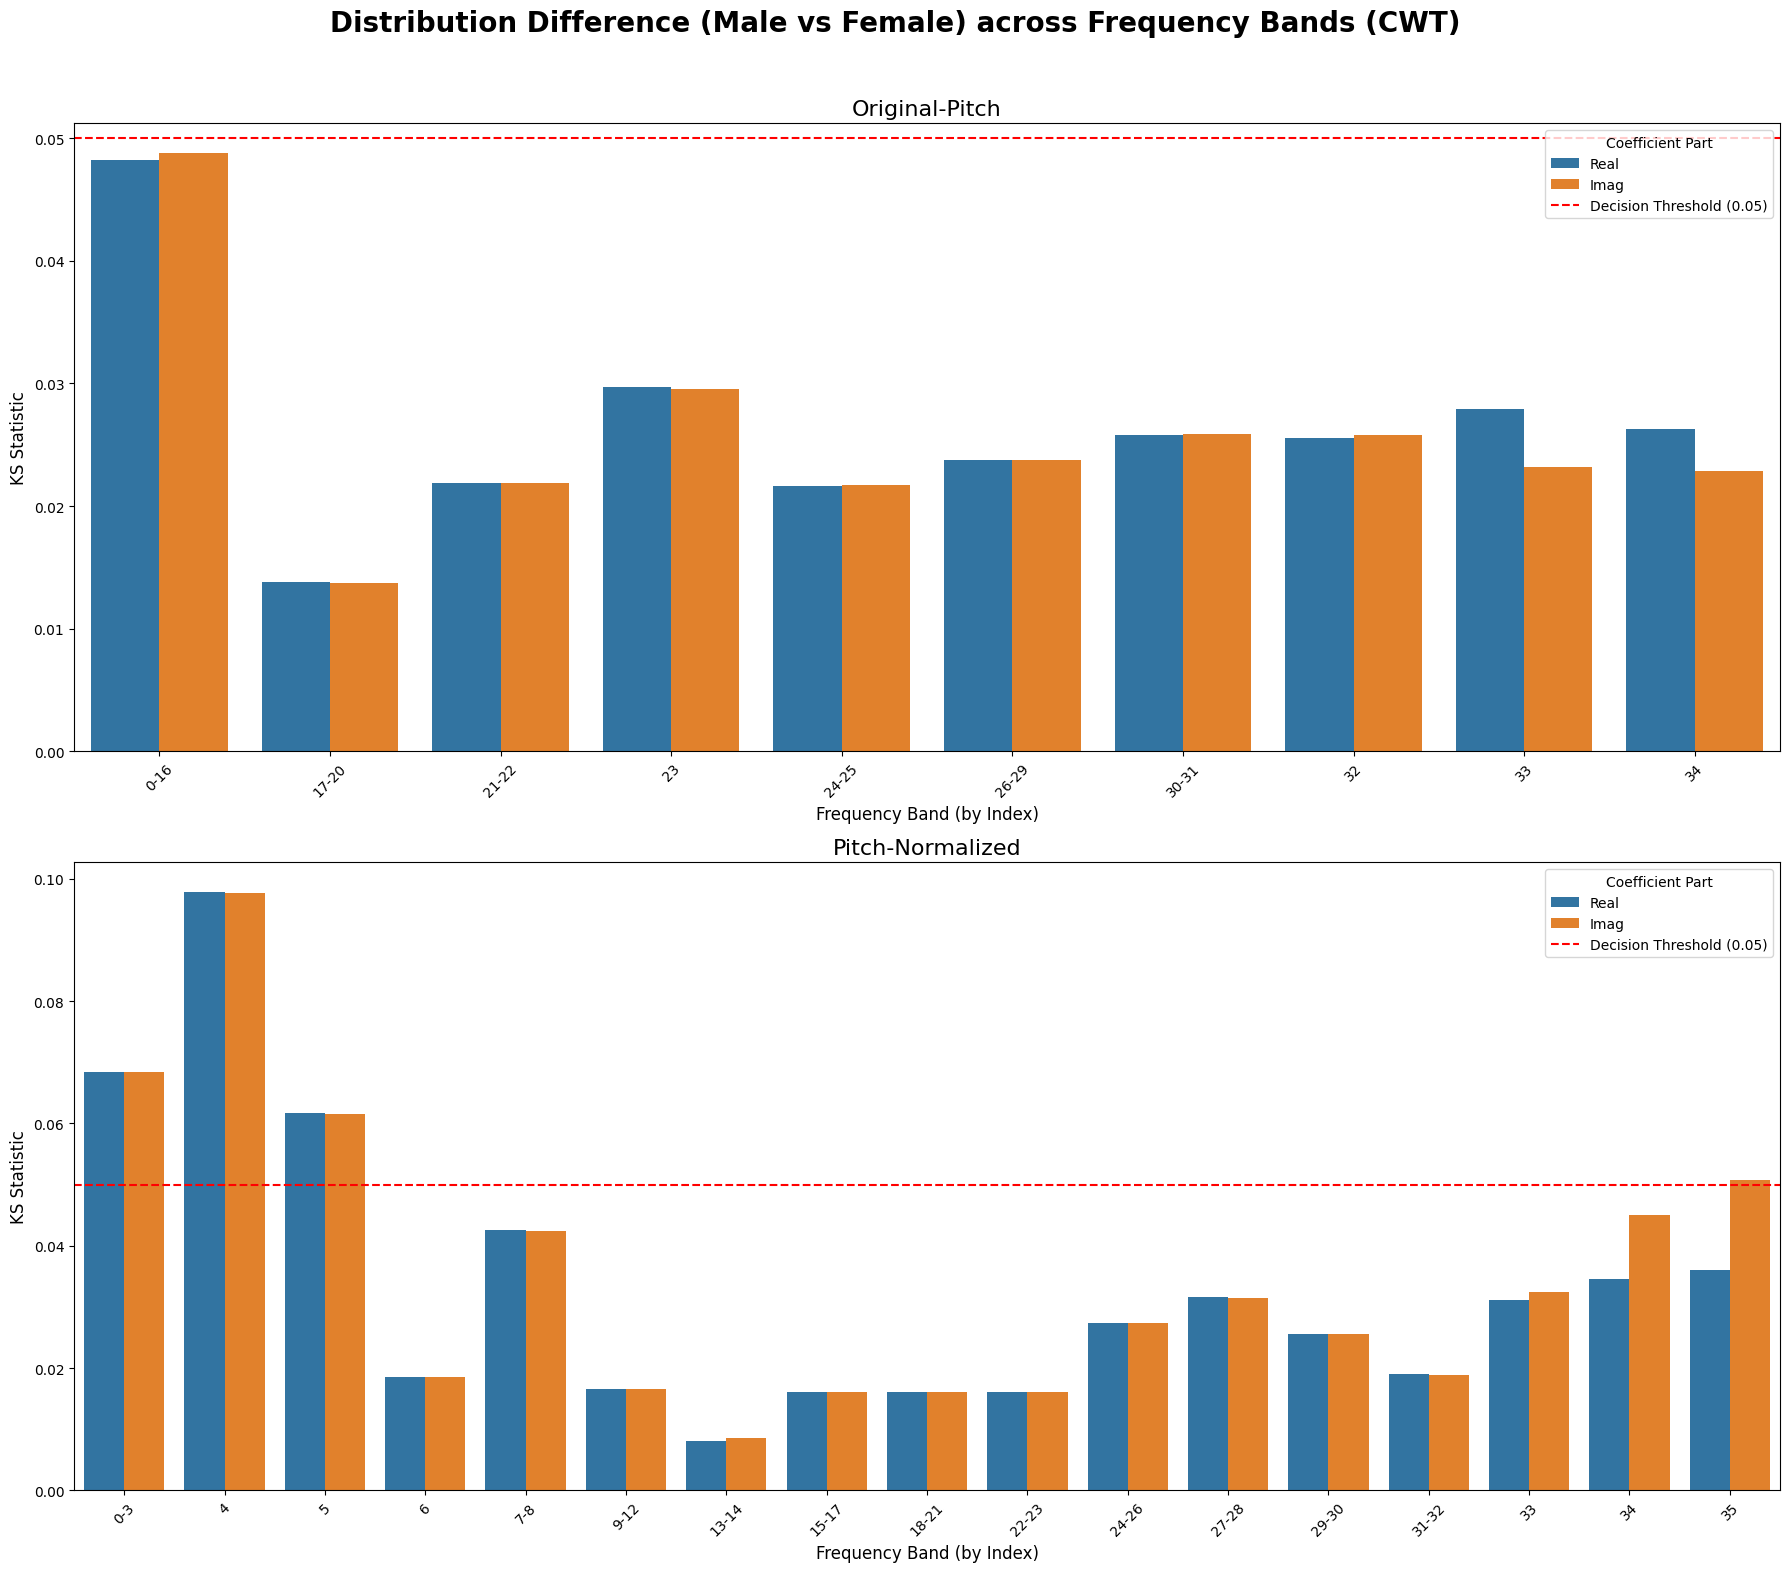

In [ ]:
if not all_files_exist:
    print("\n❗️Analysis could not be completed due to missing files. Cannot generate report.")
else:
    print("\n" + "#"*60)
    print(f"### Analysis Report: {CATEGORY_NAME.replace('_', ' ').title()} ###")
    print("#"*60 + "\n")
    
    for experiment_name, result_df in all_results.items():
        print(f"--- Results for: {experiment_name} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]}) ---")
        if result_df.empty:
            print("  - No results to display for this experiment.")
            continue
        
        significant_diffs = result_df[
            (result_df['ks_stat_real'] > KS_THRESHOLD) | 
            (result_df['ks_stat_imag'] > KS_THRESHOLD)
        ]
        print(f"In {len(result_df)} bands, {len(significant_diffs)} have a difference greater than the threshold {KS_THRESHOLD}.")
        print(result_df.round(3).to_string(index=False))
        print("\n")

    # --- Visualization ---
    fig, axes = plt.subplots(len(all_results), 1, figsize=(18, 8 * len(all_results)), sharex=False)
    if len(all_results) == 1: axes = [axes]
    fig.suptitle(f'Distribution Difference ({GROUP_NAMES[0].title()} vs {GROUP_NAMES[1].title()}) across Frequency Bands ({transform_affix.upper()})', fontsize=20, weight='bold')

    for ax, (experiment_name, result_df) in zip(axes, all_results.items()):
        if result_df.empty:
            ax.text(0.5, 0.5, 'No data to plot for this experiment.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(experiment_name, fontsize=16)
            continue
        
        plot_df = result_df.melt(
            id_vars=['band_indices'], 
            value_vars=['ks_stat_real', 'ks_stat_imag'],
            var_name='Coefficient Part',
            value_name='KS Statistic'
        )
        plot_df['Coefficient Part'] = plot_df['Coefficient Part'].str.replace('ks_stat_', '').str.title()
        
        # Create the bar plot
        sns.barplot(ax=ax, data=plot_df, x='band_indices', y='KS Statistic', hue='Coefficient Part')
        
        # Add the decision threshold line
        ax.axhline(y=KS_THRESHOLD, color='r', linestyle='--', label=f'Decision Threshold ({KS_THRESHOLD})')
        
        ax.set_title(experiment_name, fontsize=16)
        ax.set_xlabel('Frequency Band (by Index)', fontsize=12)
        ax.set_ylabel('KS Statistic', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Coefficient Part')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
